<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/Individual/Individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Individualus namų darbas: Ryžių rūšies klasifikavimas**
---
##**1. Duomenų rinkinio aprašymas**

Šiame darbe naudojamas [„Rice (Cammeo and Osmancik)“ duomenų rinkinys](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik).

*   **Šaltinis:** Duomenys surinkti iš ryžių grūdų nuotraukų, naudojant vaizdų apdorojimo metodus.
*   **Dydis:** Rinkinyje yra 3810 įrašų.
*   **Požymiai (Features):** Kiekvienas įrašas turi 7 morfologinius (geometrinius) požymius: *Area (plotas), Perimeter (perimetras), Major_Axis_Length, Minor_Axis_Length, Eccentricity, Convex_Area, Extent.*
*   **Tikslas (Target):** Klasifikavimo kintamasis Class, turintis dvi reikšmes: Cammeo ir Osmancik.

Tai yra binarinės klasifikacijos uždavinys, skirtas automatiškai atskirti ryžių rūšį pagal jų fizines savybes.

---
##**2. Hipotezė**

Tikimasi, kad giliojo mokymo (Deep Learning) modeliai, ypač tie, kurie naudoja sudėtingesnes architektūras (kaip 1D-CNN), sugebės geriau aptikti netiesinius ryšius tarp geometrinių parametrų ir pasieks didesnį tikslumą nei klasikiniai mašininio mokymo algoritmai (pvz., Random Forest), kurie gali būti riboti tiesiniais sprendimų priėmimo būdais.

---
##**3. Darbo tikslas ir uždaviniai**

**Tikslas:** Sukurti, optimizuoti ir palyginti skirtingus mašininio mokymo bei giliojo mokymo modelius ryžių veislės klasifikavimui.

**Uždaviniai:**
1.   Atlikti duomenų žvalgomąją analizę (EDA) ir paruošimą (valymą, normalizavimą).
2.   Sukurti ir optimizuoti klasikinį ML modelį – Random Forest.
3.   Sukurti ir apmokyti tris neuroninius tinklus:
      *   Paprastą MLP (Simple Multilayer Perceptron).
      *   Gilųjį MLP (Deep MLP) su reguliarizacija.
      *   Konvoliucinį tinklą 1D-CNN.
4.   Palyginti modelių tikslumą, klaidų matricas bei ROC kreives ir pateikti išvadas.


## **4. Duomenų importavimas, tvarkymas ir žvalgomoji analizė**
---
Šiame etape duomenys buvo įkelti iš .arff formato, patikrinta jų kokybė ir atlikta vizualizacija.

**Atlikti veiksmai:**
*   Patikrinta, ar nėra trūkstamų reikšmių (jų nebuvo).
*   Išanalizuotas klasių balansas (Osmancik: 2180, Cammeo: 1630).
*   Sudaryta koreliacijų matrica parodė stiprų ryšį tarp dydžio parametrų (pvz., Plotas ir Perimetras).
*   Duomenys padalinti į mokymo (80%) ir testavimo (20%) imtis.
*   **Svarbu:** Atliktas duomenų standartizavimas (StandardScaler), kas yra kritiškai svarbu neuroninių tinklų konvergavimui.




Duomenų pavyzdys:


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo



Duomenų struktūra:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.3+ KB
None

Trūkstamos reikšmės:
Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64

Klasių pasiskirstymas:
Class
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64


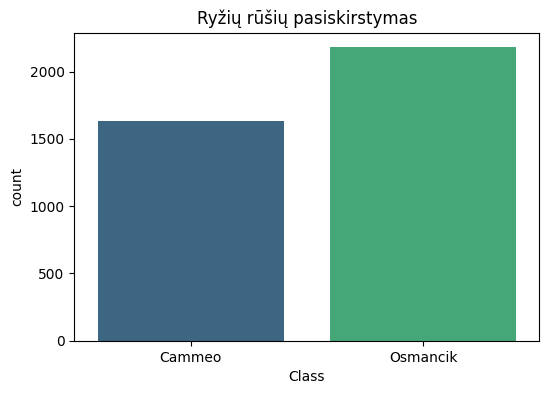

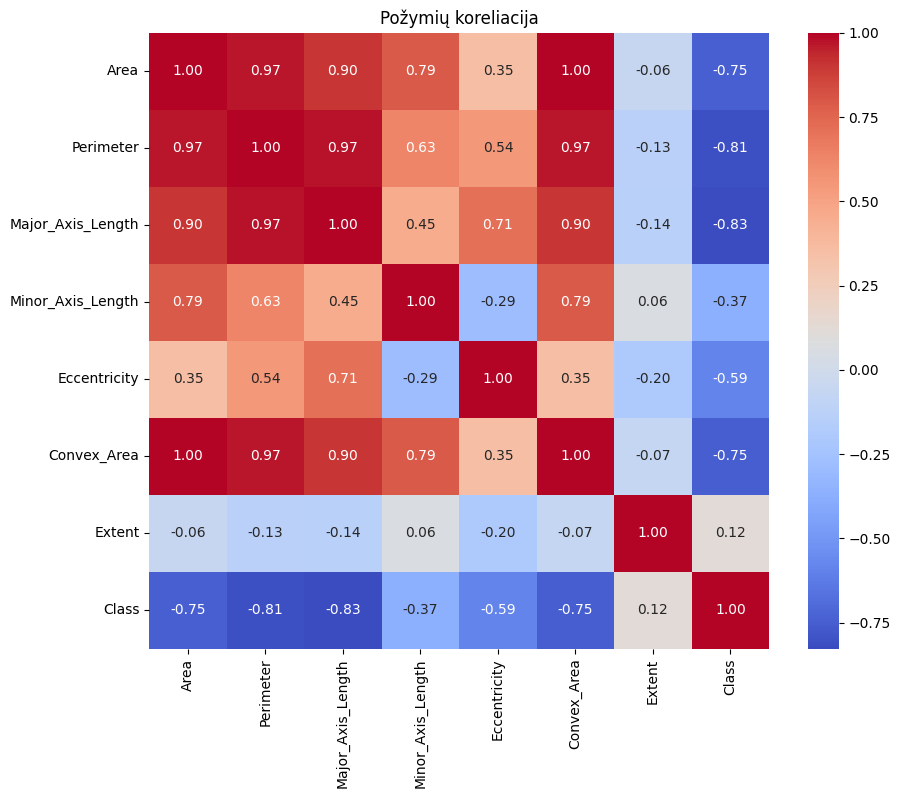


Klasės po kodavimo: [0 1]
Mokymo aibės dydis: (3048, 7)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff # Reikalinga .arff failams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- 1. DUOMENŲ ĮKĖLIMAS (Iš .arff failo) ---

# Nuskaitome failą
# Svarbu: įsitikinkite, kad failas 'Rice_Cammeo_Osmancik.arff' įkeltas į Colab failų juostą
data, meta = arff.loadarff('Rice_Cammeo_Osmancik.arff')

# Konvertuojame į Pandas DataFrame
df = pd.DataFrame(data)

# .arff failuose tekstiniai stulpeliai (pvz., klasė) dažnai būna 'bytes' formatu (b'Cammeo').
# Reikia juos dekoduoti į paprastą 'string'.
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode('utf-8')

print("Duomenų pavyzdys:")
display(df.head())

print("\nDuomenų struktūra:")
print(df.info())

# --- 2. TVARKYMAS ---
# Patikriname trūkstamas reikšmes
print(f"\nTrūkstamos reikšmės:\n{df.isnull().sum()}")

# Patikriname klasių balansą
print("\nKlasių pasiskirstymas:")
print(df['Class'].value_counts())

# --- 3. ŽVALGOMOJI ANALIZĖ (EDA) ---

# Vizualizuojame klases
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False)
plt.title("Ryžių rūšių pasiskirstymas")
plt.show()

# Koreliacijų matrica
# Pirmiausia reikia laikinai koduoti klases skaičiais, kad matytume koreliaciją
df_corr = df.copy()
df_corr['Class'] = LabelEncoder().fit_transform(df_corr['Class'])

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Požymių koreliacija")
plt.show()

# --- 4. PARUOŠIMAS MODELIAVIMUI ---

# Atskiriame X ir y
X = df.drop('Class', axis=1)
y = df['Class']

# Koduojame tekstines klases (Cammeo -> 0, Osmancik -> 1)
le = LabelEncoder()
y = le.fit_transform(y)
print(f"\nKlasės po kodavimo: {np.unique(y)}")
# Išsaugome klasių pavadinimus ateičiai
class_names = le.classes_

# Daliname į mokymo ir testavimo aibes (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizavimas (StandardScaler) - būtinas neuroniniams tinklams
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Mokymo aibės dydis: {X_train_scaled.shape}")

## **5. Mašininio mokymo algoritmų kūrimas**
---
Pagal užduoties reikalavimus, sukurti modeliai naudojant vieną klasikinį ML metodą ir kelis neuroninius tinklus.

### **5.1. Klasikinis metodas: Random Forest**

Pasirinktas Random Forest algoritmas dėl jo atsparumo persimokymui ir gebėjimo dirbti su koreliuotais duomenimis.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# --- KLASIKINIS MODELIS: RANDOM FOREST ---

# 1. Nustatome parametrų tinklelį paieškai
param_grid = {
    'n_estimators': [50, 100, 200],       # Kiek medžių sukurti
    'max_depth': [None, 10, 20],          # Maksimalus medžio gylis
    'min_samples_split': [2, 5, 10],      # Mažiausias imčių skaičius šakai skelti
    'max_features': ['sqrt', 'log2']      # Kiek požymių naudoti kiekvienam medžiui
}

# 2. Inicijuojame modelį
rf = RandomForestClassifier(random_state=42)

print("Vykdoma parametrų paieška Random Forest modeliui...")
grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

# 3. Geriausias modelis
best_rf = grid.best_estimator_
print(f"\nGeriausi parametrai: {grid.best_params_}")

# 4. Prognozė ir vertinimas
y_pred_rf = best_rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Tikslumas: {acc_rf:.4f}")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# Išsaugome tikimybes ROC kreivei (vėliau)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

Vykdoma parametrų paieška Random Forest modeliui...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Geriausi parametrai: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Tikslumas: 0.9278
              precision    recall  f1-score   support

      Cammeo       0.93      0.91      0.92       350
    Osmancik       0.93      0.94      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.93      0.93       762
weighted avg       0.93      0.93      0.93       762



###**5.2. Neuroniniai tinklai (MLP ir CNN)**

Sukurti trys skirtingo sudėtingumo tinklai:
1.   **Simple MLP:** Bazinis tinklas su vienu paslėptu sluoksniu.
2.   **Deep MLP:** Tinklas su keliais sluoksniais, naudojantis BatchNormalization stabilumui ir Dropout persimokymo prevencijai.
3.   **1D-CNN:** Konvoliucinis tinklas, pritaikytas lenteliniams duomenims, siekiant rasti paslėptus ryšius tarp požymių.



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# --- 1-asis NEURONINIS TINKLAS (Paprastas) ---
# Tik vienas paslėptas sluoksnis

def create_simple_model():
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_1 = create_simple_model()

# Mokymas
print("Mokomas gilusis tinklas...")
history_1 = model_1.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Vertinimas
loss_1, acc_1 = model_1.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Paprasto NN tikslumas: {acc_1:.4f}")

Mokomas gilusis tinklas...
Paprasto NN tikslumas: 0.9318


Mokomas gilusis tinklas...
Gilaus NN tikslumas: 0.9239


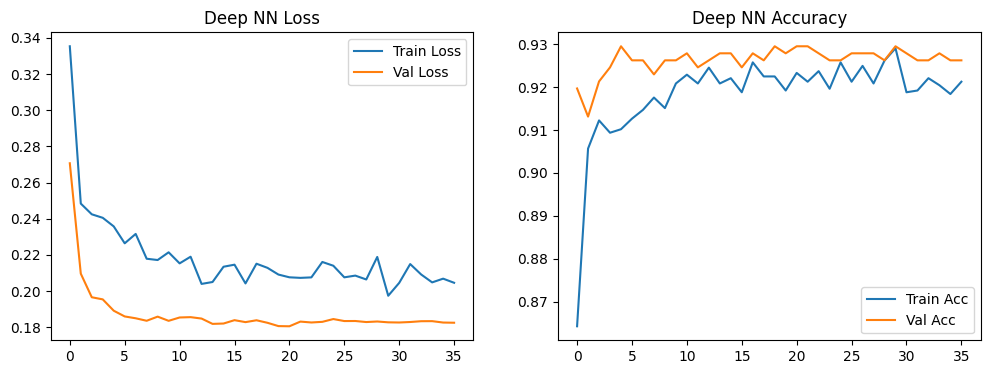

In [8]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 2-asis NEURONINIS TINKLAS (Gilus ir Optimizuotas) ---
# Daugiau sluoksnių, Dropout (reguliavimas), BatchNormalization

def create_deep_model():
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = create_deep_model()

# Callbacks (Sustabdyti, jei nebesimoko)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Mokymas
print("Mokomas gilusis tinklas...")
history_2 = model_2.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150, # Leidžiame mokytis ilgai, nes early_stop sustabdys
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Vertinimas
loss_2, acc_2 = model_2.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Gilaus NN tikslumas: {acc_2:.4f}")

# Mokymosi kreivės
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title('Deep NN Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Train Acc')
plt.plot(history_2.history['val_accuracy'], label='Val Acc')
plt.title('Deep NN Accuracy')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# --- DUOMENŲ PARUOŠIMAS CNN TINKLUI ---
# CNN tikisi įėjimo formos: [Samples, Time Steps, Features]
# Mūsų atveju "Time Steps" yra 7 (požymių skaičius), o "Features" yra 1 (vienas kanalas)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

def create_cnn_model():
    model = Sequential([
        Input(shape=(7, 1)),
        Conv1D(filters=32, kernel_size=2, activation='relu'),
        BatchNormalization(),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(), # Arba GlobalAveragePooling1D()
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_cnn = create_cnn_model()

# Mokymas
print("Mokomas 1D-CNN tinklas...")
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    # Galite naudoti tuos pačius callbacks kaip Deep MLP, jei turite apsibrėžę
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Vertinimas
loss_cnn, acc_cnn = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"1D-CNN Tikslumas: {acc_cnn:.4f}")

Mokomas 1D-CNN tinklas...
1D-CNN Tikslumas: 0.9252


##**6. Parametrų analizė**
---
Siekiant geriausio tikslumo, buvo atliktas hiperparametrų derinimas:
* **Random Forest:** Naudotas GridSearchCV metodas. Išbandytos kombinacijos:
    * n_estimators: [50, 100, 200]
    * max_depth: [None, 10, 20]
    * min_samples_split: [2, 5, 10]
    * Rasti geriausi parametrai automatiškai pritaikyti galutiniam modeliui.
* **Neuroniniai tinklai:**
    * Optimizuotas mokymosi greitis (learning_rate).
    * Pritaikytas EarlyStopping (sustabdymas, kai modelis nustoja tobulėti) ir ReduceLROnPlateau (mokymosi greičio mažinimas), kad būtų pasiektas geriausias rezultatas be persimokymo.

##**7. Tarpusavio metodų tikslumo palyginimas**
---

Šiame skyriuje lyginami visi keturi modeliai naudojant:
1.   **Tikslumą (Accuracy)** testavimo aibėje.
2.   **Klaidų matricas (Confusion Matrix)**, kad matytume, kur modeliai klysta.
3.   **ROC kreives ir AUC**, kad įvertintume modelių gebėjimą atskirti klases.




=== Modelių Palyginimas ===


,Modelis,Tikslumas
1,Simple MLP,0.931759
0,Random Forest,0.927822
3,1D-CNN,0.925197
2,Deep MLP,0.923885


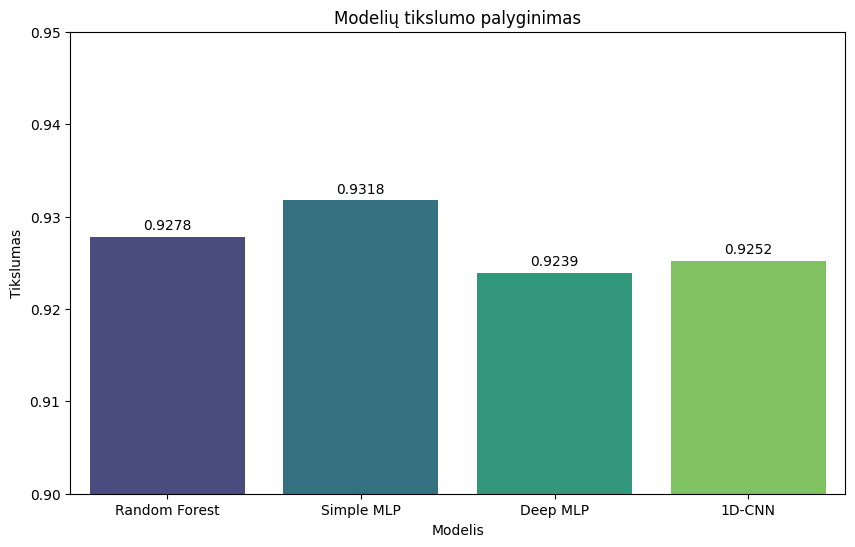

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


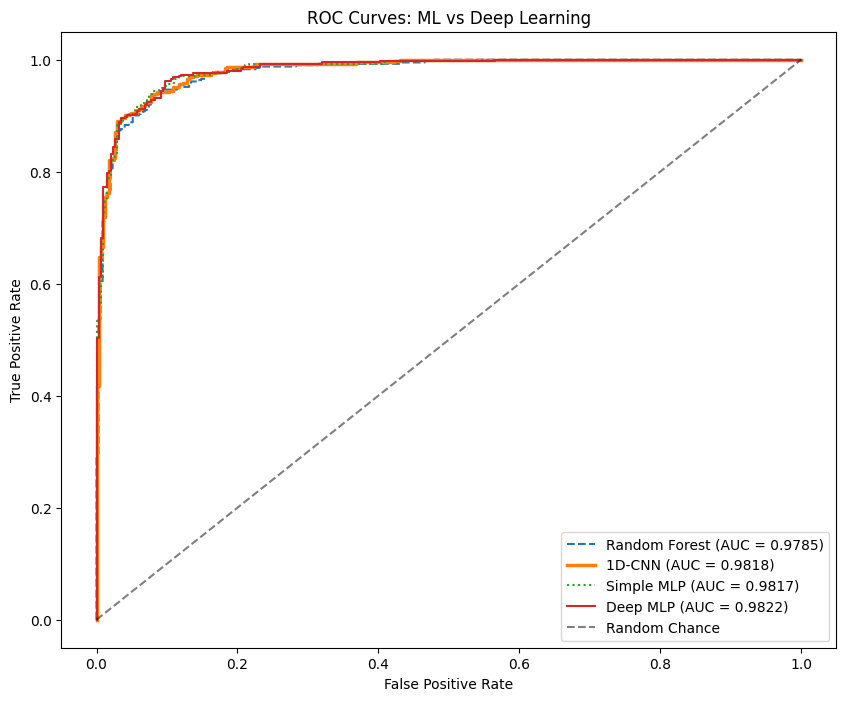

In [10]:
from sklearn.metrics import roc_curve, auc

# --- 1. REZULTATŲ LENTELĖ ---
results = pd.DataFrame({
    'Modelis': ['Random Forest', 'Simple MLP', 'Deep MLP', '1D-CNN'],
    'Tikslumas': [acc_rf, acc_1, acc_2, acc_cnn]
})

print("=== Modelių Palyginimas ===")
display(results.sort_values(by='Tikslumas', ascending=False))

# Grafikas
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Modelis', y='Tikslumas', data=results, hue='Modelis', palette='viridis', legend=False)
plt.ylim(0.90, 0.95)
plt.title("Modelių tikslumo palyginimas")
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=3)
plt.show()

# --- 2. ROC KREIVĖS ---
# Prognozės (NN modeliai jau turi suskaičiuotas prognozes iš anksčiau)
y_prob_nn1 = model_1.predict(X_test_scaled).ravel()
y_prob_nn2 = model_2.predict(X_test_scaled).ravel()
y_prob_cnn = model_cnn.predict(X_test_cnn).ravel()

plt.figure(figsize=(10, 8))

# Random Forest kreivė
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.4f})', linestyle='--')

# NN kreivės
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_prob_cnn)
plt.plot(fpr_cnn, tpr_cnn, label=f'1D-CNN (AUC = {auc(fpr_cnn, tpr_cnn):.4f})', linewidth=2.5)

fpr_1, tpr_1, _ = roc_curve(y_test, y_prob_nn1)
plt.plot(fpr_1, tpr_1, label=f'Simple MLP (AUC = {auc(fpr_1, tpr_1):.4f})', linestyle=':')

fpr_2, tpr_2, _ = roc_curve(y_test, y_prob_nn2)
plt.plot(fpr_2, tpr_2, label=f'Deep MLP (AUC = {auc(fpr_2, tpr_2):.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: ML vs Deep Learning')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix

print("--- Random Forest Klaidų matrica ---")
# Random Forest jau grąžina klases (0/1), tad papildomai konvertuoti nereikia
print(confusion_matrix(y_test, y_pred_rf))

print("\n--- Simple MLP Klaidų matrica ---")
# Neuroninių tinklų išėjimą (tikimybę) verčiame į klasę (jei > 0.5, tai 1, kitaip 0)
y_pred_nn1_class = (model_1.predict(X_test_scaled) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred_nn1_class))

print("\n--- Deep MLP Klaidų matrica ---")
y_pred_nn2_class = (model_2.predict(X_test_scaled) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred_nn2_class))

print("\n--- 1D-CNN Klaidų matrica ---")
# CNN naudoja 3D duomenis (X_test_cnn)
y_pred_cnn_class = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred_cnn_class))

--- Random Forest Klaidų matrica ---
[[320  30]
 [ 25 387]]

--- Simple MLP Klaidų matrica ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[324  26]
 [ 26 386]]

--- Deep MLP Klaidų matrica ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[321  29]
 [ 29 383]]

--- 1D-CNN Klaidų matrica ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[325  25]
 [ 32 380]]


##**8. Išvados ir pastebėjimai**
---

Atlikus išsamią „Rice (Cammeo and Osmancik)“ duomenų analizę ir modeliavimą, gautos šios įžvalgos:

1.   Geriausias modelis (Simple MLP):
      *   Eksperimento nugalėtoju tapo paprasčiausias neuroninis tinklas (Simple MLP), pasiekęs aukščiausią tikslumą – 93.18%.
      *   Klaidų matricos analizė rodo, kad šis modelis buvo stabiliausias: jis padarė mažiausiai klaidų (iš viso tik 52 klaidos: 26 Cammeo ir 26 Osmancik klasėse). Tai rodo, kad ryšys tarp ryžių geometrinių savybių yra pakankamai tiesioginis, ir vienas paslėptas sluoksnis sugeba optimaliai generalizuoti duomenis be persimokymo rizikos.
2.   Modelio sudėtingumo paradoksas (Deep Learning "Overkill"):
      *   Sudėtingesnės architektūros modeliai – Deep MLP (92.39%) ir 1D-CNN (92.52%) – pasirodė prasčiau už paprastąjį tinklą.
      *   Tai rodo, kad šiam lenteliniam duomenų rinkiniui (7 požymiai) gilusis mokymas ir konvoliuciniai sluoksniai yra pertekliniai. Didelis parametrų skaičius sudėtinguose tinkluose greičiausiai lėmė tai, kad modeliai bandė įsiminti triukšmą duomenyse, užuot radę bendrą dėsningumą, arba jiems tiesiog pritrūko duomenų kiekio sudėtingoms struktūroms apmokyti.
      *   Nors 1D-CNN geriausiai atpažino Cammeo klasę (325 teisingi atvejai – geriausias rodiklis), jis padarė per daug klaidų su Osmancik klase (32 klaidos), kas sumažino bendrą tikslumą.
3.   Klasikinio ML (Random Forest) efektyvumas:
      *   Klasikinis Random Forest algoritmas (92.78%) pasirodė geriau nei sudėtingi neuroniniai tinklai (Deep MLP ir CNN) ir nusileido tik paprastam MLP tinklui (skirtumas ~0.4%).
      *   Tai patvirtina taisyklę, kad struktūruotiems duomenims "Random Forest" yra itin patikimas ir stiprus algoritmas, dažnai lenkiantis "sunkiasvorius" Deep Learning modelius.
4.   Rekomendacija:
      *   Praktiniam naudojimui rekomenduočiau Simple MLP modelį, nes jis užtikrina didžiausią tikslumą.
      *   Kaip alternatyva tinkamas ir Random Forest, jei reikalingas modelio aiškumas (interpretability) ir greitas apmokymas be sudėtingo parametrų derinimo.